#Initialization

##Mount Drive

In [1]:
!nvidia-smi -L
from google.colab import drive
drive.mount('/content/drive')

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-26ddeba8-c328-4b51-8cfd-afdd71f5865d)
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Set File Path Constants


In [0]:
PROJECT_ROOT = "/content/drive/My Drive/rob535" #Change This
TEST_FILES = "/content/drive/My Drive/rob535/test" #Change This (Path to test files)

##Imports

In [3]:
from tensorflow import keras
import os
import csv
import glob

import numpy as np
import matplotlib.pyplot as plt

os.chdir(PROJECT_ROOT)

# Evaluate

[1, 1, 2, 1, 3, 1, 0, 2, 0, 0, 2, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 2, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 2, 1, 2, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 2, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 1, 1, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 2, 0, 1, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 1, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 2, 0, 2, 2, 2, 0, 2, 2, 0, 2, 0, 0, 1, 2, 1, 1, 0, 1, 0, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 0, 2, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 2, 2, 2, 2, 2, 2, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 0, 1, 1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 2, 0, 0, 

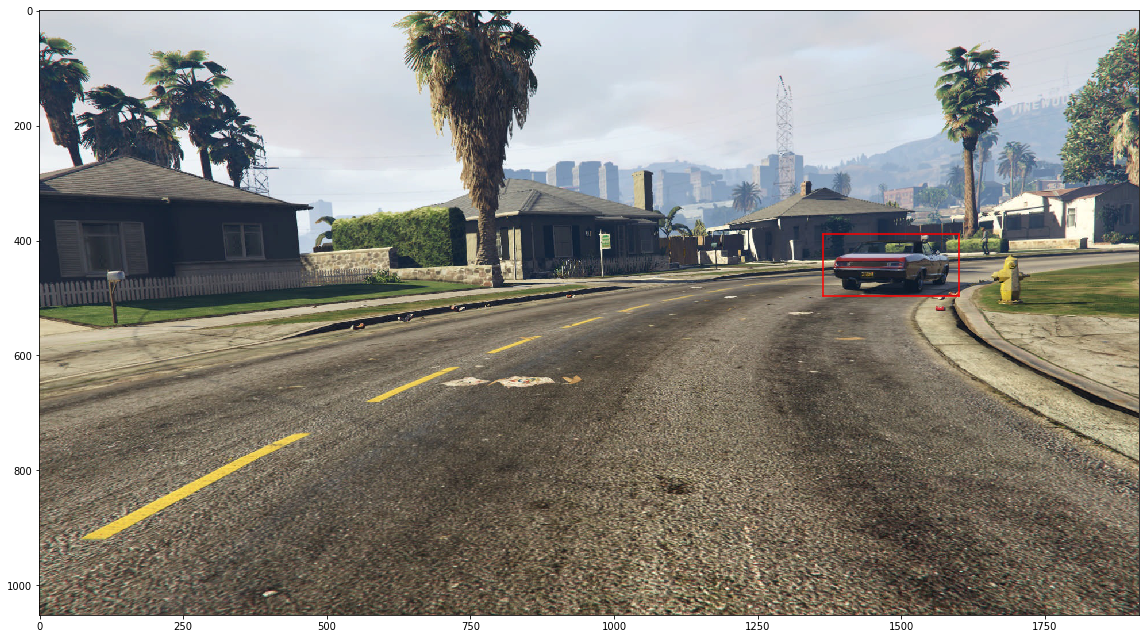

In [8]:
with open('stage2/model_architecture.json', 'r') as f:
    model = keras.models.model_from_json(f.read())

model.load_weights("stage2/model.h5")

X_test = np.load("stage2/X_test_eval.npy")
filename_map = np.load("stage2/filename_map_eval.npy")

Y_predict = model.predict(X_test)
np.savetxt("stage2/Y_predict_eval.txt", Y_predict, fmt="%f")

#create task 1 csv
data_dir = TEST_FILES
image_files_full = glob.glob(os.path.join(data_dir, "*/*_image.jpg"))

image_files = []
pred_dict = {} #maps filename -> closest detection
for i, image_file in enumerate(image_files_full):
    path_split = image_file.split(os.sep)
    image_files.append(os.path.join(path_split[-2], path_split[-1]))
    #print(image_files[i])
    pred_dict[image_files[i]] = []

for i in range(0, Y_predict.shape[0]):
    path_split = filename_map[i].split(os.sep)
    file = os.path.join(path_split[-2], path_split[-1]).replace(os.sep, "/")

    if len(pred_dict[file]) == 0 or pred_dict[file][0]["dist"] > Y_predict[i, 0]:
        tmp = {"dist": Y_predict[i, 0], "angle": Y_predict[i, 1], "label": int(X_test[i, 9]),
               "bbox": [X_test[i,0], X_test[i,1], X_test[i,2], X_test[i,3]]}
        try:
            pred_dict[file][0] = tmp
        except IndexError:
            pred_dict[file].append(tmp)

pred_labels = []
for image_file in image_files:
    if len(pred_dict[image_file]) == 0 or pred_dict[image_file][0]["dist"] > 50:
        pred_labels.append(0)
    else:
        pred_labels.append(pred_dict[image_file][0]["label"])
print(pred_labels)

with open("stage2/results-trained-resnet101-task1.csv", "w+") as results_fd:
    results_writer = csv.writer(results_fd, delimiter=",", lineterminator="\n")
    results_writer.writerow(["guid/image", "label"])
    for i, image_file in enumerate(image_files):
        results_writer.writerow([image_file.replace("_image.jpg", ""), pred_labels[i]])

#Create task2 csv
with open("stage2/template.csv") as template_fd:
    template_reader = csv.reader(template_fd, delimiter=",")
    image_files_task2 = []
    for i, row in enumerate(template_reader):
        if i % 2 == 0:
            continue
        else:
            impath = row[0].replace("/r", "_image.jpg")
            image_files_task2.append(impath)

with open("stage2/results-trained-resnet101-task2.csv", "w+") as results_fd:
    results_writer = csv.writer(results_fd, delimiter=",", lineterminator="\n")
    results_writer.writerow(["guid/image/axis", "value"])
    for i, image_file in enumerate(image_files_task2):
        result_val = pred_dict[image_file]
        if len(result_val) != 0:
            results_writer.writerow([image_file.replace("_image.jpg", "") + "/r",
                                     result_val[0]["dist"]])
            results_writer.writerow([image_file.replace("_image.jpg", "") + "/theta",
                                     result_val[0]["angle"]])
        else:
            results_writer.writerow([image_file.replace("_image.jpg", "") + "/r",
                                     25])
            results_writer.writerow([image_file.replace("_image.jpg", "") + "/theta",
                                     0])

idx = np.random.randint(0, len(image_files))
img = plt.imread(image_files_full[idx])
fig1 = plt.figure(1, figsize=(16, 9))
ax1 = fig1.add_subplot(1, 1, 1)
ax1.imshow(img)
ax1.axis('scaled')
fig1.tight_layout()

if len(pred_dict[image_files[idx]]) != 0:
    xmin = pred_dict[image_files[idx]][0]["bbox"][0]
    xmax = pred_dict[image_files[idx]][0]["bbox"][1]
    ymin = pred_dict[image_files[idx]][0]["bbox"][2]
    ymax = pred_dict[image_files[idx]][0]["bbox"][3]
    clr="red"
    ax1.plot([xmin, xmax], [ymin, ymin], color=clr)
    ax1.plot([xmin, xmin], [ymin, ymax], color=clr)
    ax1.plot([xmin, xmax], [ymax, ymax], color=clr)
    ax1.plot([xmax, xmax], [ymin, ymax], color=clr)
    print(pred_dict[image_files[idx]][0]["label"])
    print(pred_dict[image_files[idx]][0]["dist"])
    print(pred_dict[image_files[idx]][0]["angle"])


plt.show()